# Implementation
============================
#### (Using Probabilistic Graphical Models to forecast the price of crude oil)

The document contains the **implementation** of the oil trading system using graphical models.

* [The **first** part](#first) is dedicated to retrieving data from the **EIA** and **FRED**, **preprocessing** the data,and creating the **training**, **validation**, and **test** datasets.
* [The **second** part](#second) is dedicated to implementing a **regime detection model** using **Hidden Markov Models** to identify bull, bear, and stagnant regimes.


I would be using a number of Python packages, such as [pgmpy](http://pgmpy.org/) and [hmms](https://github.com/lopatovsky/HMMs) throughout the notebook and it is highly recommended that I take a deeper look at them as only a specific and relevant functionality of those packages have been used in our model.

## Data preprocessing

Data preprocessing plays an important role in Machine Learning. Our data preprocessing has four main steps;  data retrieval, data cleaning, data transformation, and data discretisation.

### Data retrieval

The first step of constructing our model is to retrieve the data from the open-data facilities. I have selected the **EIA** and **FRED** as our primary data sources. Unfortunately, both these open-data facilities do not provide Python packages to neatly retrieve data in Python, so I will have to resort to using third-party APIs. For the EIA, I are using [EIA-python](https://github.com/mra1385/EIA-python/), and for the FRED I are using [fredapi](https://github.com/mortada/fredapi).

Before beginning, I would be first be importing pandas and numpy, as they are highly required in the entire data preprocessing section.

In [ ]:
import pandas as pd
import numpy as np

I would now be retrieving data, beginning with the EIA. Before retrieving data from the EIA, I have to register with EIA's [open-data facility](https://www.eia.gov/opendata/), in return of which I shall recieve an API key, which is used as a passphrase to access data from the EIA's datacenter.

In [ ]:
!pip install myeia

In [ ]:
# Importing the library
from myeia.api import API
# the API key recieved from EIA
eia_key = "265d1f2178aaab3ceec3d364d9cc1d11";
# Initiates a session with the EIA datacenter to recieve datasets
eia = API(eia_key)

Now, I shall be making a request to retrieve data from the EIA as a pandas dataframe. EIA provides a 3,872 Short-Term Energy Outlook (STEO) datasets, with short-term (2-year) forecasts of each dataset. These datasets can be searched in EIAs [query browse](https://www.eia.gov/opendata/qb.php) facility, which also offers a catalogue of different datasets sorted by relevance. Just as an example to demonstrate, I would be retrieving the **Crude Oil Exports, Monthly**, which has a Series ID '**TOTAL.COEXPUS.M**'.

In [ ]:
# Convert to pandas dataframe
eia_data = eia.get_series(series_id="TOTAL.COEXPUS.M")
print(eia_data)


             TOTAL.COEXPUS.M
Date                        
2023-12-01          4182.548
2023-11-01            4681.1
2023-10-01          4111.908
2023-09-01          4157.249
2023-08-01          4141.492
...                      ...
1973-05-01             4.129
1973-04-01  No Data Reported
1973-03-01  No Data Reported
1973-02-01  No Data Reported
1973-01-01  No Data Reported

[612 rows x 1 columns]


### Data Cleaning

Taking a look at the dataframe, I can observe some evident inconsistencies.

Firstly, the dataframe provided by the EIA is not of the standard format **datetime**, which pandas indexing supports and provides extensive facility to. I would be writing a function which makes the index a **datetime** object so that I can convert the dataframe to a **datetime**-index dataframe for more compatibility with pandas, hmms, and pgmpy.

In [ ]:
import datetime # Using the datetime library

def convert_to_datetime(input):
    date_object = input.to_pydatetime().date()
    return date_object

# Apply to entire index
eia_data.index = eia_data.index.map(convert_to_datetime);
# Convert dataframe index to datetime64[ns] index
eia_data.index = pd.to_datetime(eia_data.index);
# pgmpy stores the column names as the variable name
eia_data.columns = ['TOTAL.COEXPUS.M'];

The second issue are **holes** in the data i.e. rows marked by a '-' (a single dash). I would be replacing these dashes by **np.nan** so that I can use pandas to fill in the holes. Usually the prevalance of these holes is very rare, but just to be on the safe side to ensure I can possibly download every dataset.

In [ ]:
# Replace the '-' with np.nan
eia_data.replace('-', np.nan, regex=True, inplace=True);
# Backward fill the holes, by filling them with the data infront.
eia_data.fillna(method='bfill', inplace=True);

Together, I can create a function carrying out the entire process so that I can easily clean EIA data in one step.

In [ ]:
def clean_EIA(data):
            data.replace('-', np.nan, regex=True, inplace=True);
            data.fillna(method='bfill', inplace=True);

            data.index = data.index.map(convert_to_datetime);
            data.index = pd.to_datetime(data.index);

The dataframe is now a time series dataframe which could be plotted as a time-series dataframe.

In [ ]:
import pandas as pd

# Assuming eia_data is a pandas DataFrame
eia_data_filtered = eia_data.replace("No Data Reported", np.nan)
print(eia_data_filtered)

            TOTAL.COEXPUS.M
Date                       
2023-12-01         4182.548
2023-11-01         4681.100
2023-10-01         4111.908
2023-09-01         4157.249
2023-08-01         4141.492
...                     ...
1973-05-01            4.129
1973-04-01              NaN
1973-03-01              NaN
1973-02-01              NaN
1973-01-01              NaN

[612 rows x 1 columns]


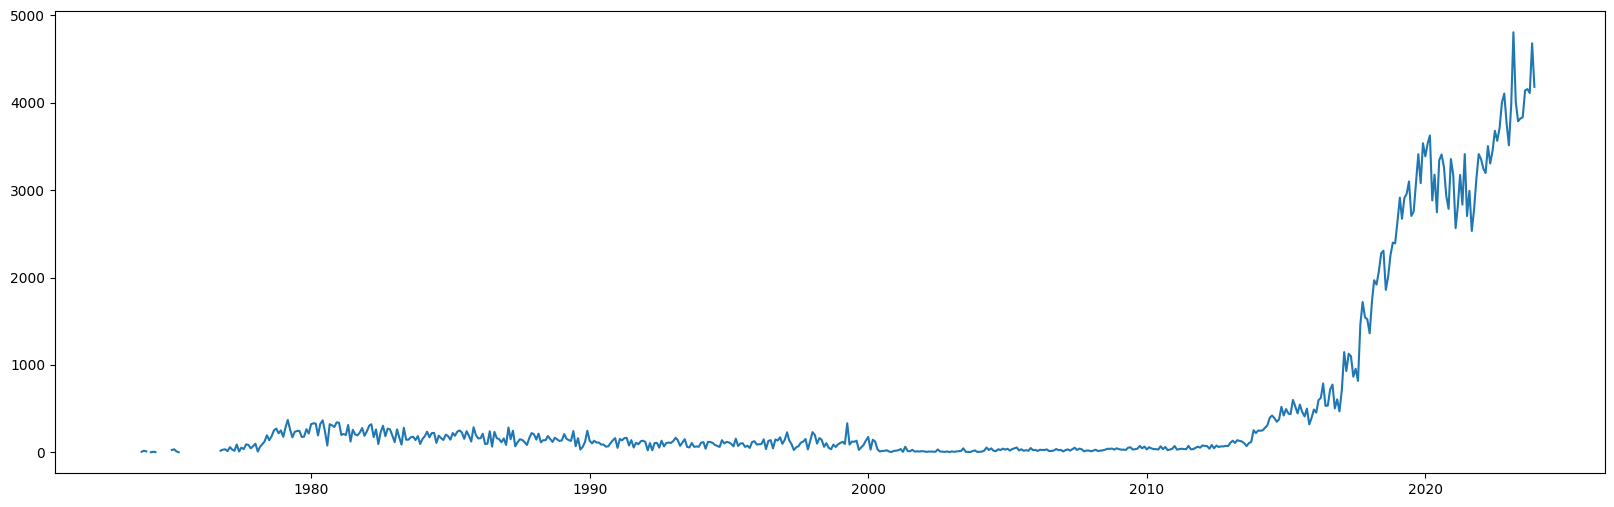

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,6));
ax.plot(eia_data_filtered);

Now, I shall be taking a look at the FRED data. Similar to [EIA-python](https://github.com/mra1385/EIA-python/), the [fredapi](https://github.com/mortada/fredapi) requires us to register with [FRED API](https://research.stlouisfed.org/docs/api/fred/) so that I can access data. I would download the **Spot Crude Oil Price: West Texas Intermediate**, having the Series ID '**WTISPLC**.'

In [ ]:
!pip install fredapi

In [ ]:
from fredapi import Fred

# FRED API key
fred_key = "029c72315e9ec4eaf3e679ec3f6a2cb3";

# Initiates a session with the FRED datacenter to recieve datasets
fred = Fred(api_key=fred_key);

# Retrieve data from FRED API
fred_data = pd.DataFrame(fred.get_series('WTISPLC'), columns=['WTISPLC']);

It is evident that the FRED, though still being a government organization, has 'ready-to-use' / 'plug'n play' data of useable quality compared to the EIA. Fortuntely, I will not be having to clean data obtained from the FRED.


### Constructing the training, validation and testing datasets (Data transformation)

As mentioned in the thesis, I need to divide our data in three portions: the training dataset, the validation dataset, and the training dataset. Given that I would be using a number of datasets from the FRED and the EIA, I would have to amalgamate these datasets into one dataframe and then slice the dataframe accordingly.

The train, validation, and test datasets are to be observed with a ratio of $80:10:10$, which is a popular ettiquette  

The choice of datasets has been described in the thesis.

In [ ]:
# Dataset series ID from the EIA

datasets_eia  = [

                        'STEO.RGDPQ_NONOECD.M',
                        'STEO.RGDPQ_OECD.M',

                        'STEO.PAPR_NONOPEC.M',
                        'STEO.PAPR_OPEC.M',

                        'STEO.PATC_OECD.M',
                        'STEO.PATC_NON_OECD.M',


                        'STEO.COPRPUS.M',
                        'STEO.CORIPUS.M',
                        'PET.MCRIMXX2.M',

                        'STEO.FOREX_WORLD.M',

                        'STEO.PASC_OECD_T3.M',

                        'STEO.COPS_OPEC.M',
                        'STEO.COPC_OPEC.M',

                        'STEO.T3_STCHANGE_OOECD.M',
                        'STEO.T3_STCHANGE_NOECD.M',
                ];

# Dataset series ID from the FRED

datasets_fred = [
                        'CPIENGSL',
                        'CAPG211S',
                        'CAPUTLG211S',
                        'IPG211S',
                        'IPG211111CN',
                        'INDPRO',
                        'IPN213111N',
                        'PCU211211',

                ];

To construct the training, validation, and testing datasets, I need to first **concatenate** the datasets into one dataframe, and then slice it.

In [ ]:
data_merge = []; # List of dataframes to be concatenated
# Adding EIA datasets
for series_id in datasets_eia:
    df = pd.DataFrame(eia.get_series(series_id="TOTAL.COEXPUS.M"))
    df.columns = [series_id];
    data_merge.append(df);
# Adding FRED datasets
for series_id in datasets_fred:
    df = pd.DataFrame(fred.get_series(series_id), columns=[series_id]);
    data_merge.append(df);

I have to create two additional columns; one which has the current crude oil price, and the other for the price of crude oil next month (forecast). This will be used to forecast the price of oil and hence allow us to make buy/sell decisions based on that forecast.

In [ ]:
datasets = datasets_eia + datasets_fred + ['WTISPLC', 'forecast'];

current =  pd.DataFrame(fred.get_series('WTISPLC'), columns=['WTISPLC']);
forecast = pd.DataFrame(fred.get_series('WTISPLC').shift(-1),
                        columns=['forecast']);

data_merge.append(current);
data_merge.append(forecast);

I have to amalgamate all datasets together in a single dataframe, therefore I would use the pandas **concatenate** function. This would allow us to find the intersection of the date intervals of all dataframes and construct a single dataframe on a common time interval.

In [ ]:
data = pd.concat(data_merge, axis=1, join='inner');

Slicing our dataframe in train, validation, and testing datasets,

In [ ]:
train_data = data[: int(data.shape[0] * 0.80)];
vald_data = data[int(0.80 * data.shape[0]) : int(0.90 * data.shape[0])];
test_data = data[int(0.90* data.shape[0]) : int(data.shape[0])];

### Data Discretisation

The data I have collected is non-categorical data; it is unlabelled and continuous. Belief networks have variables, each having discrete **states**, and therefore I have to reduce our data from prices to a set of states, such as bull, bear, and stagnant markets. In order to detect these (hidden) states, I have to use graphical models called **Hidden Markov Models**. The process of detecting hidden states in time-series data is called **Regime Detection**.

## Regime Detection

I would be using Python library called [hmms](https://github.com/lopatovsky/HMMs) for implementing the **Hidden Markov Models**.

A **Hidden Markov Model** is a 5-tuple $(Q, \sum, \Pi, A, B)$, where $Q = \{q_{1}, \cdots, q_{N}\}$ is a finite set of $\mathcal{N}$ states, $\sum = \{s_1, \cdots, s_{N}\}$ is the set of $\mathcal{M}$ possible symbols (emissions) in the language, $\Pi = \{\pi_{i}\}$  is the initial probability vector, $A = \{a_{ij}\}$ is the state transition probability matrix, and $B = \{b_i(v_k)\}$ is the emission probability matrix. The HMM can be denoted by $\lambda = (\Pi, A, B)$.

For detecting regimes in time-series data, I would be using **Hidden Markov Models**, with the difference between consecutive months being the symbols $\sum$ (1 - increase / 0 - decrease), the hidden states, $Q$ being the **bull**, **bear**, **stagnant** market regimes.

Let us use '**WTISPL**' (Spot Crude Oil Price: West Texas Intermediate)  of  and try to identify regimes in the time series.

In [ ]:
!pip install hmms

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.8/524.8 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.3 MB/s eta 0:00:00
  Created wheel for hmms: filename=hmms-0.2.3-cp310-cp310-linux_x86_64.whl size=2152525 sha256=36612ec951bdc1c49e14ba0093b81bf4a6a073d5d0c6b58c29fdfe8f2d5f7335
  Stored in directory: /root/.cache/pip/wheels/aa/6f/a4/1dbae244341f24881dce9465aa533729d2ae870cff3866070f
Successfully built hmms


In [ ]:
import hmms

In [ ]:
price = train_data['WTISPLC'];

I will now try to transform the time series which represents the output emissions, with $1$ representing an increase in the price from the previous month and $0$ representing a decrease in the price of the oil.

In [ ]:
# The first value is NaN as there is not a previous month to compare with
price_diff = price.diff()[1:];

# Replacing the change with 1 if positive, else 0
e_seq = np.array(price_diff.apply(lambda x: 1 if x > 0 else 0).values);

Given that I have obtained the output (observed emission sequence), I can now use the **Baum-Welch algorithm** to learn the parameters of the HMM generating this data.

I have earlier described the **Baum-Ilch algorithm** in the Background and Literature review, and I would be using the implementation provided [hmms](https://github.com/lopatovsky/HMMs) to learn the parameters.

**IT IS VERY IMPORTANT** to note I can **only** use the training data to train the HMM as I are assuming to be blind to the testing data. However, I would be observing predictions on the validation dataset and will tune our model to fit it, and I would be using the testing dataframe to test the final performance of the tuned model after validation.

We will create a model with random parameters, that will be eventually trained to match the data - a discrete time HMM of three hidden states (bull, bear, or stagnant) and two output variables (increase or decrease).

In [ ]:
dhmm_r = hmms.DtHMM.random(3 , 2);

Given that the $\texttt{hmms.DtHMM}$ takes a list of arrays no creater than length $32$, I will have to split our array in arrays each of length $32$ or less.

In [ ]:
e_seq = np.array_split(e_seq, 32);

### Baum-Welch Algorithm

I would now be using the **Baum-Welch algorithm** to learn the parameters of the HMM generating the time-series.

The probability of the reestimated model after each iteration should ideally be closer that the (unknown) generator's model, however chances might be the estimation fell in the local optima.

Unfortunately, the financial time-series data do not have fixed parameters, so the HMM has to be trained everytime when live-trading, when using the **k-fold cross-validation** training method.

In [ ]:
dhmm_r.baum_welch(e_seq, 100); # 100 iterations

iteration  1 / 100
iteration  2 / 100
iteration  3 / 100
iteration  4 / 100
iteration  5 / 100
iteration  6 / 100
iteration  7 / 100
iteration  8 / 100
iteration  9 / 100
iteration  10 / 100
iteration  11 / 100
iteration  12 / 100
iteration  13 / 100
iteration  14 / 100
iteration  15 / 100
iteration  16 / 100
iteration  17 / 100
iteration  18 / 100
iteration  19 / 100
iteration  20 / 100
iteration  21 / 100
iteration  22 / 100
iteration  23 / 100
iteration  24 / 100
iteration  25 / 100
iteration  26 / 100
iteration  27 / 100
iteration  28 / 100
iteration  29 / 100
iteration  30 / 100
iteration  31 / 100
iteration  32 / 100
iteration  33 / 100
iteration  34 / 100
iteration  35 / 100
iteration  36 / 100
iteration  37 / 100
iteration  38 / 100
iteration  39 / 100
iteration  40 / 100
iteration  41 / 100
iteration  42 / 100
iteration  43 / 100
iteration  44 / 100
iteration  45 / 100
iteration  46 / 100
iteration  47 / 100
iteration  48 / 100
iteration  49 / 100
iteration  50 / 100
iteration

I have now learnt the parameters generating the emission sequence.

In [ ]:
hmms.print_parameters( dhmm_r );

Initial probabilities (π) :


,0
0,0.386280
1,0.044766
2,0.568954


Transition probabilities matrix (A):


,0,1,2
0,0.417494,0.276793,0.305713
1,0.469719,0.529470,0.000811
2,0.028759,0.620292,0.350949


Emission probabilities matrix (B):


,0,1
0,0.058006,0.941994
1,0.837929,0.162071
2,0.992281,0.007719


### Viterbi Algorithm

Now, given I now have parameters $\lambda$ and the emitted observation sequence $\texttt{e_seq}$, I can use the **Viterbi Algorithm** to identify the most likely **state-transition** path (i.e. **market regimes**) in the financial time-series.

In [ ]:
np.int = np.int64
np.float = np.float64
np.bool = np.bool_

(log_prob, s_seq) = dhmm_r.viterbi(np.concatenate(e_seq).ravel().astype(np.int64))

### Multicolored time series plot

Now, I will be plotting this graph in a **multicolored** time-series plot to observe how well the regimes have been identified.

First, I will have to make a dataframe which has the both the price and the associated regime the time-series data is in.

In [ ]:
# Add price
price_plot = pd.DataFrame(price[1:], index=price[1:].index);

# Add a column representing the regime
price_plot['Regime'] = s_seq;

# Add a column representing the increase or decrease in price
price_plot['diff'] = price_diff;

I do not know, however, which state represents which regime. Given that the bull regimes should have a high positive change in price, bear regimes should have a high negative change, and stagnant regimes are closer to zero, I can use these properties to tell which state represents which regime.

In [ ]:
# Get means of all assigned states
means = price_plot.groupby(['Regime'])['diff'].mean();
lst_1 = means.index.tolist();
lst_2 = means.sort_values().index.tolist();

map_regimes = dict(zip(lst_2, lst_1));

price_plot['Regime'] = price_plot['Regime'].map(map_regimes);

Plotting the data as **multi-colored** time series:

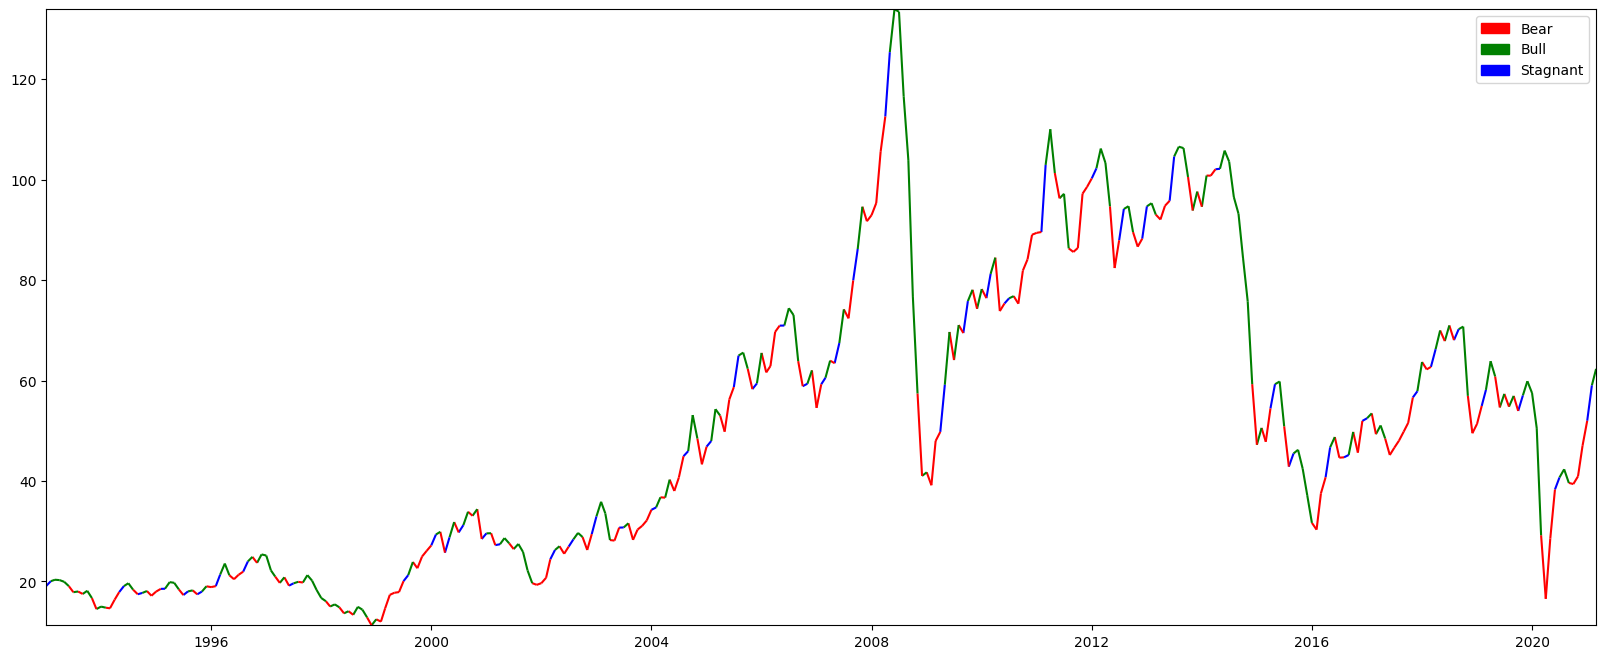

In [ ]:
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib.collections import LineCollection
from matplotlib.colors import Colormap, ListedColormap, BoundaryNorm

fig, ax1 = plt.subplots(figsize=(20,8));
ax.plot(price_plot['WTISPLC']);

# Make 0 (Bear) - red, 1 (Stagnant) - blue, 2 (Bull) - green

cmap   = ListedColormap(['r','b','g'],'indexed');
norm   = BoundaryNorm(range(3 + 1), cmap.N);
inxval = mdates.date2num(price_plot['WTISPLC'].index.to_pydatetime());
points = np.array([inxval, price_plot['WTISPLC']]).T.reshape(-1, 1, 2);
segments = np.concatenate([points[:-1], points[1:]], axis=1);

lc = LineCollection(segments, cmap=cmap, norm=norm);
lc.set_array(price_plot['Regime']);
plt.gca().add_collection(lc);
plt.xlim(price_plot['WTISPLC'].index.min(), price_plot['WTISPLC'].index.max());
plt.ylim(price_plot['WTISPLC'].min(), price_plot['WTISPLC'].max());

r_patch = mpatches.Patch(color='red', label='Bear');
g_patch = mpatches.Patch(color='green', label='Bull');
b_patch = mpatches.Patch(color='blue', label='Stagnant');

plt.legend(handles=[r_patch, g_patch, b_patch]);

plt.show();